In [178]:
#| echo: false
#| output: false
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfd = tfp.distributions
tfb = tfp.bijectors
tfkl = tf.keras.layers
tfpl = tfp.layers

import matplotlib.pyplot as plt
plt.style.use('bmh')

How to build and calibrate models of stochastic processes arising from SDEs with Keras

## Stochastic differential equations
A [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) is a sequence of random variables $X_t$ indexed by a time parameter $t$ that can be discrete or continuous. The dynamics of a continuous process is often described by a [stochastic differential equation](https://en.wikipedia.org/wiki/Stochastic_differential_equation) (SDE) of the form

$$
dX_t = \mu(X_t, t)dt + \sigma(X_t, t)dW_t,
$$

with a drift $\mu(X, t)$ and a volatility $\sigma(X, t)$.

In statistical physics, the random variable $X_t$ can describe the positions at time $t$ of a population of molecules swimming around in water, bumping randomly into smaller molecules following a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process) $W_t$. In finance, $X_t$ can describe the uncertainty over an asset price in the future due to the random behavior of market participants.

Solving this SDE means finding the probability distribution of $X_t$ for $t>0$, given the initial distribution of $X_{t=0}$. This can be done by specifying the probability density function (PDF) $p(x; t)$ for $t>0$ given the initial PDF $p(x; t=0)$ (here the semicolon indicates that $x$ is the value realized by the random variable and $t$ the time parameter).

For certain special cases of $\mu(X, t)$ and $\sigma(X, t)$, that include Brownian motions (where $\mu$ and $\sigma$ are both constant), the solution follows a normal distribution $X_t \sim \mathcal{N}(m(t), s(t))$ where the parameters $m(t)$ and $s(t)$ obey certain ordinary differential equations, which can be solved up to any accuracy with standard methods.

## Euler-Maruyama
In general, one relies instead on numerical approximations, for instance the [Euler–Maruyama method](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) that generates approximated samples of the process $X_t$ at discretized time steps $t_1, \dots, t_N$,

$$
X_{i+1} = X_i + \mu(X_i, t_i)\Delta t_i + \sigma(X_i, t_i)\,\sqrt{\Delta t_i}\, Z_i, \quad Z_i \sim \mathcal{N}(0,1).
$$

In TensorFlow Probability, this can be implemented as a `tfd.MarkovChain` distribution. The following code snippet implements a geometric Brownian motion.

In [204]:
drift = .1
volatility = .2

n_steps = 51
time = tf.linspace(0., (n_steps-1)*time_step, n_steps)
time_step = np.mean(np.diff(time))

geom_brownian_motion = tfd.MarkovChain(
            initial_state_prior=tfd.Deterministic(1.),
            transition_fn=lambda _, x: tfd.Normal(
                loc=x + x * drift * time_step,
                scale=x * volatility * tf.sqrt(time_step)),
            num_steps=n_steps,
            name='geometric_brownian_motion')

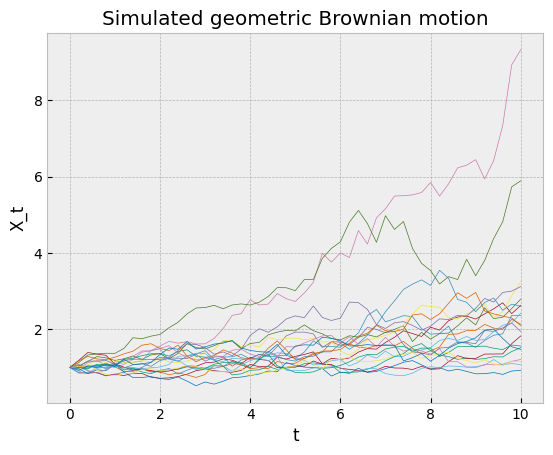

In [199]:
#| echo: false
plt.plot(time, tf.transpose(geom_brownian_motion.sample(20)), linewidth=.5)
plt.title('Simulated geometric Brownian motion')
plt.xlabel('t')
plt.ylabel('X_t')
plt.show()

Sometimes, one is interested only in expected values of the form

$$
\mathbb{E}\left[f(X_t)\right] = \int f(x)\,p(x; t)\,\mathrm{d}x,
$$

and these samples are usually good enough to find Monte Carlo estimates

$$
\mathbb{E}\left[f(X_t)\right] \approx \sum_k f(\hat X_{t, k}),
$$

where the sum is taken over several realizations of the Euler-Maruyama integration.

Other times, one needs to know the probability density function at a given time $t$, for instance in inference problems with models that have a stochastic process component. Markov chains could provide that in theory, but at the expense of marginalizing out all the intermediate steps.

## Fokker-Planck
Physicists came up with an alternative solution by deriving a partial differential equation (PDE) for $p(x;t)$ that is equivalent to the SDE, the [Fokker-Planck](https://en.wikipedia.org/wiki/Fokker%E2%80%93Planck_equation) equation

$$
\frac{\partial p(x; t)}{\partial t} = -\frac{\partial}{\partial x}[\mu(x, t)p(x; t)] + \frac{1}{2}\frac{\partial^2}{\partial x^2}[\sigma^2(x, t)p(x; t)].
$$

It describes how the initial distribution $p(x;0)$ is shifting under the influence of the drift term and diffusing because of the volatility term. For the non-physicists who want to try this at home, $p(x;0)$ could indicate the position of a tea bag in a cup of hot water, $\mu(x, t)$ could describe how the water has been swirled, and $\sigma^2(x, t)$ would depend on the thermal agitation of the water.

These PDEs are usually solved numerically. This can be difficult when $\mu(X, t)$ renders the equation stiff (this happens often in models of noisy electric circuits used for biophysical measurements) or in high-dimensional problems (for instance joint distributions of stock prices in large markets).

A limitation of this modelling approach is the difficulty to sample from a distribution given by its probability density function. This requires specialized algorithms, so in practice it is probably better to rely on Euler-Maruyama methods for sampling, and Fokker-Planck equations for density evaluation.

## Probabilistic machine learning
Probabilistic machine learning provides a third approach, where one gets a model that can both evaluate densitities and generate new samples. The idea is to first generate training data with the Euler-Maruyama method, and then use machine learning to find


alternatively, one can use machine learning to estimate the density from samples generated by Euler-Maruyama simulations, good for sampling and density estimation

In [180]:
# Generate synthetic training data
n = 1000
s = geom_brownian_motion.sample(n)

t = tf.reshape(tf.stack(s.shape[0]*[time], axis=0)[:,1:], (-1, 1))
X = tf.reshape(s[:, 1:], (-1, 1))

# Conditional density estimation with MADE.
made = tfb.AutoregressiveNetwork(
  params=2,
  hidden_units=[32, 32],
  event_shape=(1,),
  conditional=True,
  kernel_initializer=tfk.initializers.VarianceScaling(0.1, seed=42),
  conditional_event_shape=(1,)
)

distribution = tfd.TransformedDistribution(
  distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.),
                          sample_shape=(1,)),
  bijector= tfb.Chain([tfb.Exp(), tfb.MaskedAutoregressiveFlow(made, name='maf')])
)

# Construct and fit a model.
X_ = tfkl.Input(shape=(X.shape[-1],), dtype=tf.float32)
t_ = tfkl.Input(shape=(t.shape[-1],), dtype=tf.float32)
log_prob_ = distribution.log_prob(
  X_, bijector_kwargs={'maf': {'conditional_input': t_}})
model = tfk.Model([X_, t_], log_prob_)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.003),
              loss=lambda _, log_prob: -log_prob)

batch_size = 500

history = model.fit(x=[X, t],
                    y=np.zeros((X.shape[0], 0), dtype=np.float32),
                    batch_size=batch_size,
                    epochs=70,
                    steps_per_epoch=X.shape[0] // batch_size,
                    shuffle=True,
                    verbose=False)

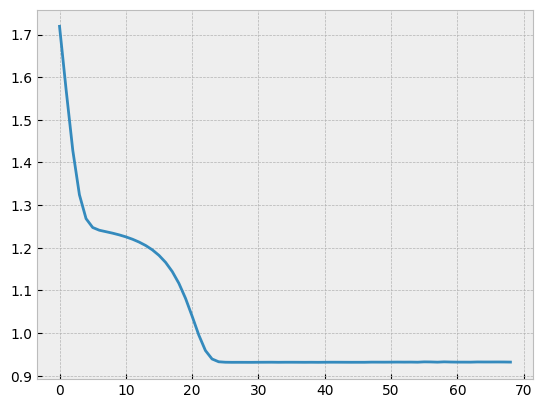

In [208]:
#| echo: false
#| output: false
plt.plot(history.history['loss'][1:])

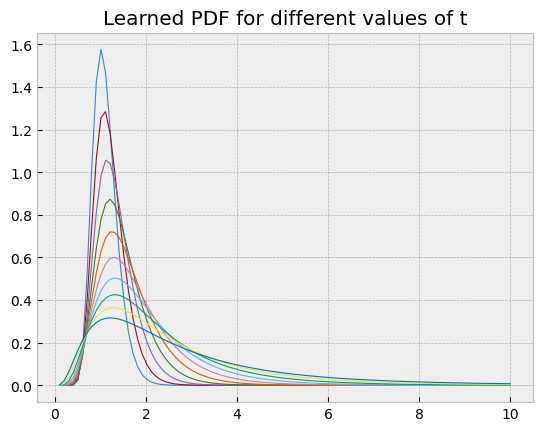

In [212]:
#| echo: false
sample_space = tf.linspace(0.0, 10, 100)
for i in range(10):
    density = distribution.prob(sample_space[...,None], bijector_kwargs={'maf': {'conditional_input': (i+1)*tf.ones((1,1), tf.float32)}})
    plt.plot(sample_space, density, linewidth=.8)
plt.title('Learned PDF for different values of t')
plt.show()

These estimated probability density functions can be compared with the true solution

$$
X_t = X_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t},
$$

of the geometric Brownian motion SDE, which follows a log-normal distribution. This was the main reason for using this example.

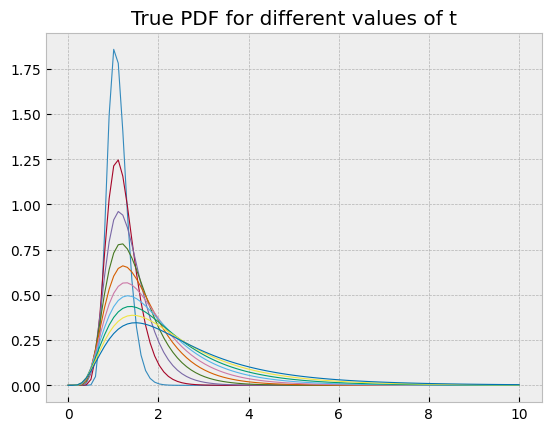

In [213]:
#| echo: false
for i in range(1, 11):
    dist = tfd.LogNormal(i * (drift - volatility**2/2), tf.sqrt(i*1.) * volatility)
    plt.plot(sample_space, dist.prob(sample_space), linewidth=.8)
plt.title('True PDF for different values of t')
plt.show()

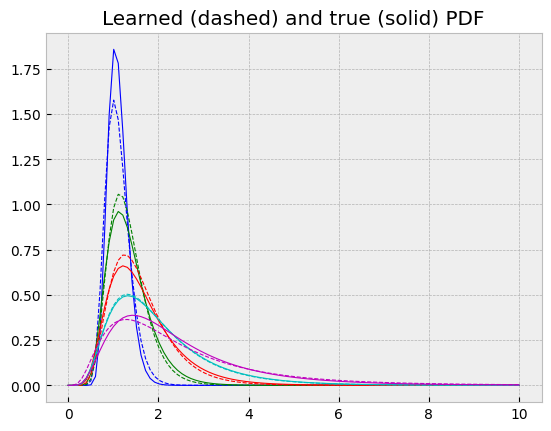

In [214]:
#| echo: false
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

for i in range(5):
    density = distribution.prob(sample_space[...,None], bijector_kwargs={'maf': {'conditional_input': (2*i+1)*tf.ones((1,1), tf.float32)}})
    plt.plot(sample_space, density, '--', linewidth=.8, color=colors[i])
    dist = tfd.LogNormal((2*i+1) * (growth - volatility**2/2), tf.sqrt((2*i+1)*1.) * volatility)
    plt.plot(sample_space, dist.prob(sample_space), linewidth=.8, color=colors[i])
plt.title('Learned (dashed) and true (solid) PDF')
plt.show()